In [1]:
## uncomment only if running from google.colab
# clone the git reposetory
!git clone https://github.com/RoyElkabetz/SEOP-and-NMR.git

# add path to .py files for import
import sys
sys.path.insert(1, "/content/SEOP-and-NMR/src")

Cloning into 'SEOP-and-NMR'...
remote: Enumerating objects: 449, done.
remote: Counting objects: 100% (449/449), done.
remote: Compressing objects: 100% (388/388), done.
remote: Total 449 (delta 245), reused 131 (delta 52), pack-reused 0
Receiving objects: 100% (449/449), 8.98 MiB | 14.97 MiB/s, done.
Resolving deltas: 100% (245/245), done.


In [2]:
# PYTHON PACKAGES
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import inv
import matplotlib.pyplot as plt
import copy as cp
np.random.seed(14)

# MY PACKAGES
import physical_constant_units as phy
import measurements as meas
import environment as env
import xenon as xe
import utils

/content/SEOP-and-NMR/src/measurements.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Single species simulation without magnetic noise $(B_{noise}=0)$

In this simulation we assume there is no magnetic noise and no effective magnetic field of the alkali spin. Then, the phase of the Xenon with respect to the drive is given by

\begin{align}
    \phi_{129} &= -\frac{\gamma^{129}_{Xe}B_0}{\Gamma_2^{129}}-\boxed{\frac{\gamma^{129}_{Xe}B_{noise}=0}{\Gamma_2^{129}}}-\frac{\omega_r}{\Gamma_2^{129}}+\frac{\omega^{129}_{rf}}{\Gamma_2^{129}}
\end{align}


### Single species simulation for sigmoid like world rotation

| Xenon 129:
| ----------
| gyromagnetic ratio:     -74406900.0
| T1:                     30
| T2:                     8
| K0:                     [0.0259 0.02   0.3   ]
| Kt:                     [0. 0. 0.]
| K steady:               [0. 0. 0.]
| Xenon129 Environment:
| ----------
| B0:                     1e-10
| B_noise:                0.0
| ωd_x:                   0.0
| Ωd_x:                   0.0
| ωd_y:                   -0.00744069
| Ωd_y:                   0.12909944487358055
| Ωr:                     3.720075976020836e-46


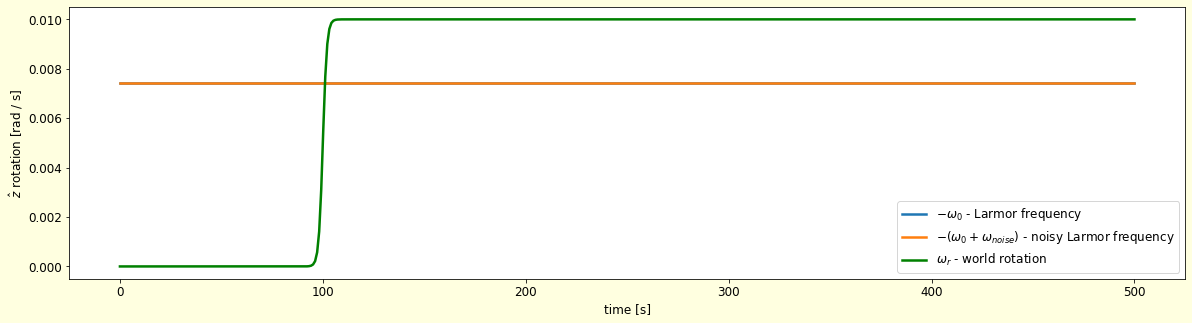

In [5]:
# solver parameters
t_final = 500                                                 # [s]
dt = 1                                                        # [s] 
steps = int(t_final // dt ) 
ts = np.linspace(0, t_final, steps)                           # [s]

# world rotation parameters
#wr = 30 * utils.gaussian(ts, 600, 40)                        # [rad / s]     
wr = 0.01 * utils.sigmoid(ts, 1, 100)                         # [rad / s]   

# Xenon parameters
g129 = phy.G129                        # gyromagnetic ratio [rad  s^-1  T^-1]
t1 = 30                                # [s]
t2 = 8                                 # [s]
Rse = np.array([0, 0, 0.1]) * t1       # |K| / s

# Environment parameters
B0 = 1e-6 * phy.G2T * np.ones_like(ts)                         # [Tesla]
Bnoise = np.zeros_like(ts)                                     # [Tesla]
Ad_y = 2 * np.sqrt((1 / t1) * (1 / t2)) * np.ones_like(ts)     # [rad / s]
wd_y = g129 * 1e-6 * phy.G2T * np.ones_like(ts)                # [rad / s]
Ad_x = np.zeros_like(ts)                                       # [rad / s]
wd_x = np.zeros_like(ts)                                       # [rad / s]

# initialize Xenon
Xe129 = xe.Xenon(gamma=g129, t1=t1, t2=t2, K0=np.array([0.0259, 0.02, 0.3]), ts=t_final, dt=dt, name='129')
Xe129.set_spin_exchange_amp(Rse)
Xe129.display_params()

# initialize Environment
env129 = env.Environment()
env129.set_state(wr=wr, B0=B0, Bnoise=Bnoise, Ad_y=Ad_y, wd_y=wd_y, Ad_x=Ad_x, wd_x=wd_x)
env129.display_params()

# plot world rotation
fig = plt.figure(figsize=(20, 5))
ax = plt.subplot()
ax.plot(ts, -Xe129.gamma * B0, label='$-\omega_0$ - Larmor frequency')
ax.plot(ts, -Xe129.gamma * (B0 + Bnoise), label='$-(\omega_0 + \omega_{noise})$ - noisy Larmor frequency')
ax.plot(ts, wr, label='$\omega_r$ - world rotation', color='green')
ax.set_ylabel('$\hat{z}$ rotation [rad / s]')
ax.set_xlabel('time [s]')
ax.legend()
plt.show()




### Solve and plot results

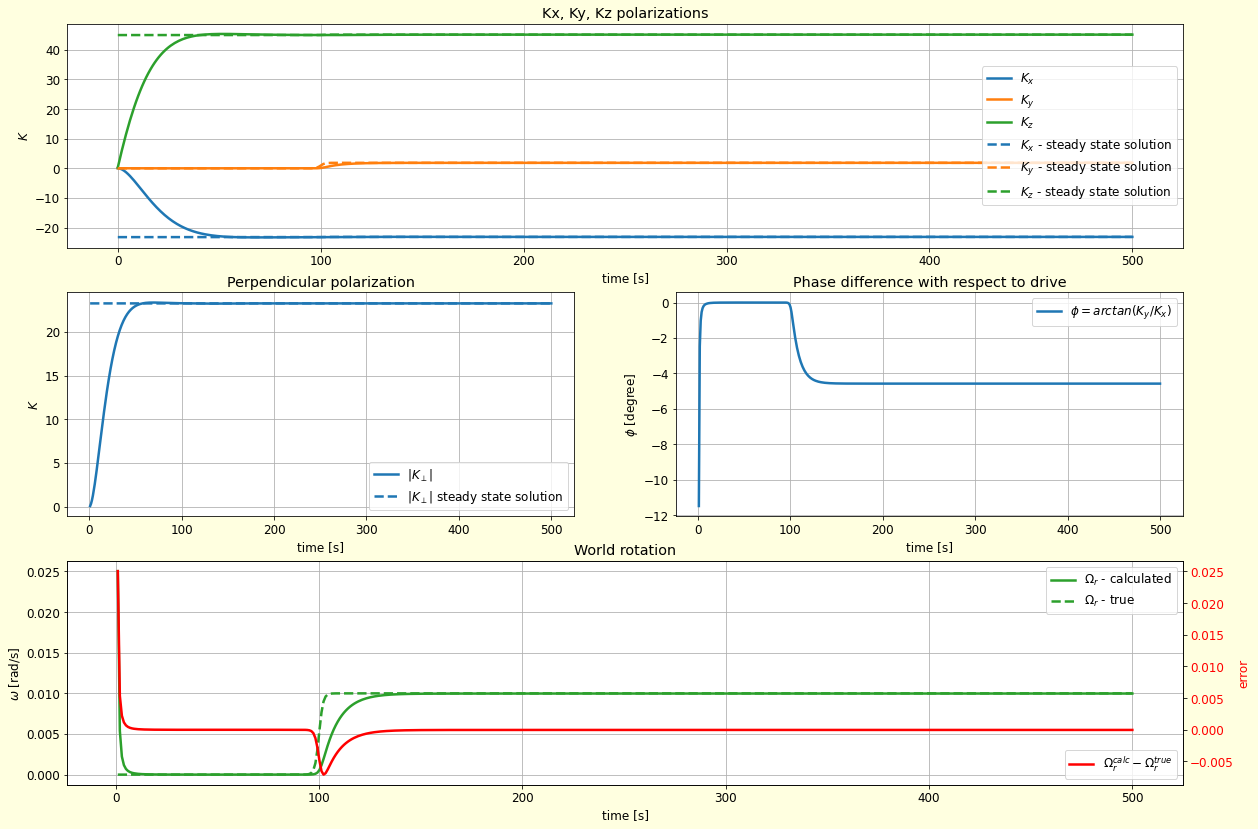

In [6]:
# run solver and save dynamics
Xe129.solve_dynamics(env129)
Xe129.plot_results(env129)

### Dynamic range simulation

/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


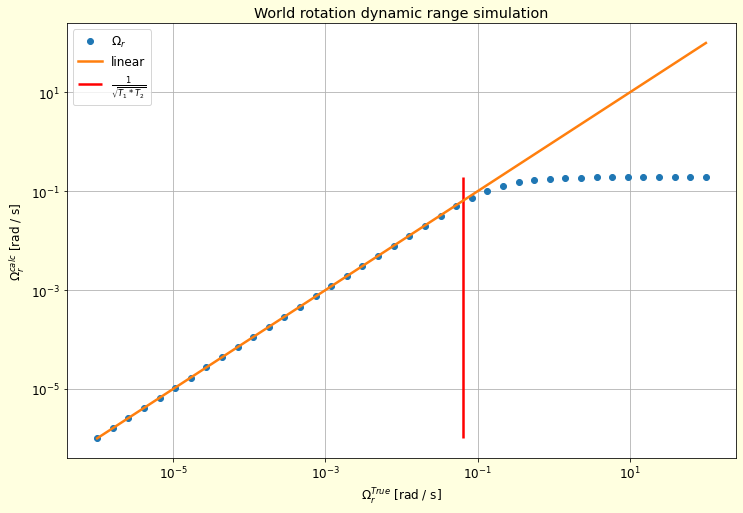

In [7]:
#@title Dynamic range
t1 = 30 #@param {type:"slider", min:1, max:100, step:1}
t2 = 8 #@param {type:"slider", min:1, max:100, step:1}
Xenon_isotop = "129" #@param ["129", "131"]

if Xenon_isotop == '129':
    gyro = phy.G129
if Xenon_isotop == '131':
    gyro = phy.G131

wr_amplitudes = np.logspace(-6, 2, 40)
meas.single_species_Open_Loop_dynamic_range_simulation(gyro, t1, t2, wr_amplitudes)

So we see that without magnetic noise we can extract the world rotation from the xenon129 spin measurements as long as the rotation is not too strong $$\omega_r \leq \frac{1}{\sqrt{T_1 * T_2}}$$

### Single specie simulation for sine wave like world rotation (starting simulation from steady state solution)

| Xenon129 Environment:
| ----------
| B0:                     1e-10
| B_noise:                0.0
| ωd_x:                   0.0
| Ωd_x:                   0.0
| ωd_y:                   -0.00744069
| Ωd_y:                   0.12909944487358055
| Ωr:                     0.0
| Xenon 129:
| ----------
| gyromagnetic ratio:     -74406900.0
| T1:                     30
| T2:                     8
| K0:                     [0.0259 0.02   0.3   ]
| Kt:                     [0. 0. 0.]
| K steady:               [0. 0. 0.]


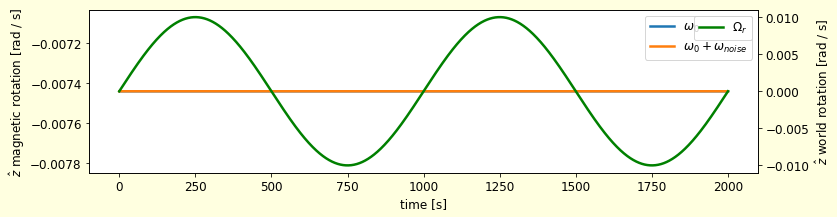

In [8]:
# solver parameters
freq = 0.001                    # [Hz]
period = 1 / freq               # [s]
num_periods = 2
t_final = num_periods * period  # [s]
dt = period / 1000              # [s]

steps = int(t_final // dt)
ts1 = np.linspace(0, dt, 2)
ts = np.linspace(0, t_final, steps)

# world rotation parameters
wr = 0.01 * np.sin(2 * np.pi * freq * ts)             # rad / s

# Xenon parameters
g129 = phy.G129                        # gyromagnetic ratio [rad  s^-1  T^-1]
t1 = 30                                # s
t2 = 8                                 # s
Rse = np.array([0, 0, 0.1]) * t1       # |K| / s

# Environment parameters
B0 = 1e-6 * phy.G2T * np.ones_like(ts)                             # Tesla
Bnoise = 0 * phy.G2T * np.zeros_like(ts)                        # Tesla
Ad_y = 2 * np.sqrt((1 / t1) * (1 / t2)) * np.ones_like(ts)      # rad / s
wd_y = g129 * 1e-6 * phy.G2T * np.ones_like(ts)                    # rad / s
Ad_x = np.zeros_like(ts)                                        # rad / s
wd_x = np.zeros_like(ts)                                        # rad / s


# initialize Environment
env129 = env.Environment()
env129.set_state(wr=wr, B0=B0, Bnoise=Bnoise, Ad_y=Ad_y, wd_y=wd_y, Ad_x=Ad_x, wd_x=wd_x)
env129.display_params()

# initialize Xenon
Xe129 = xe.Xenon(gamma=g129, t1=t1, t2=t2, K0=np.array([0.0259, 0.02, 0.3]), ts=t_final, dt=dt, name='129')
Xe129.set_spin_exchange_amp(Rse)
Xe129.display_params()
Xe129.set_bloch_matrix(env129)
Xe129.init_with_steady_state()



# plot world rotation
fig = plt.figure(figsize=(12, 3))
ax = plt.subplot()
ax.plot(ts, Xe129.gamma * B0, label='$\omega_0$')
ax.plot(ts, Xe129.gamma * (B0 + Bnoise), label='$\omega_0 + \omega_{noise}$')
ax.set_ylabel('$\hat{z}$ magnetic rotation [rad / s]')
ax.set_xlabel('time [s]')
ax.legend()
ax1 = ax.twinx()
ax1.plot(ts, wr, label='$\Omega_r$', color='green')
ax1.set_ylabel('$\hat{z}$ world rotation [rad / s]')
ax1.legend()
plt.show()

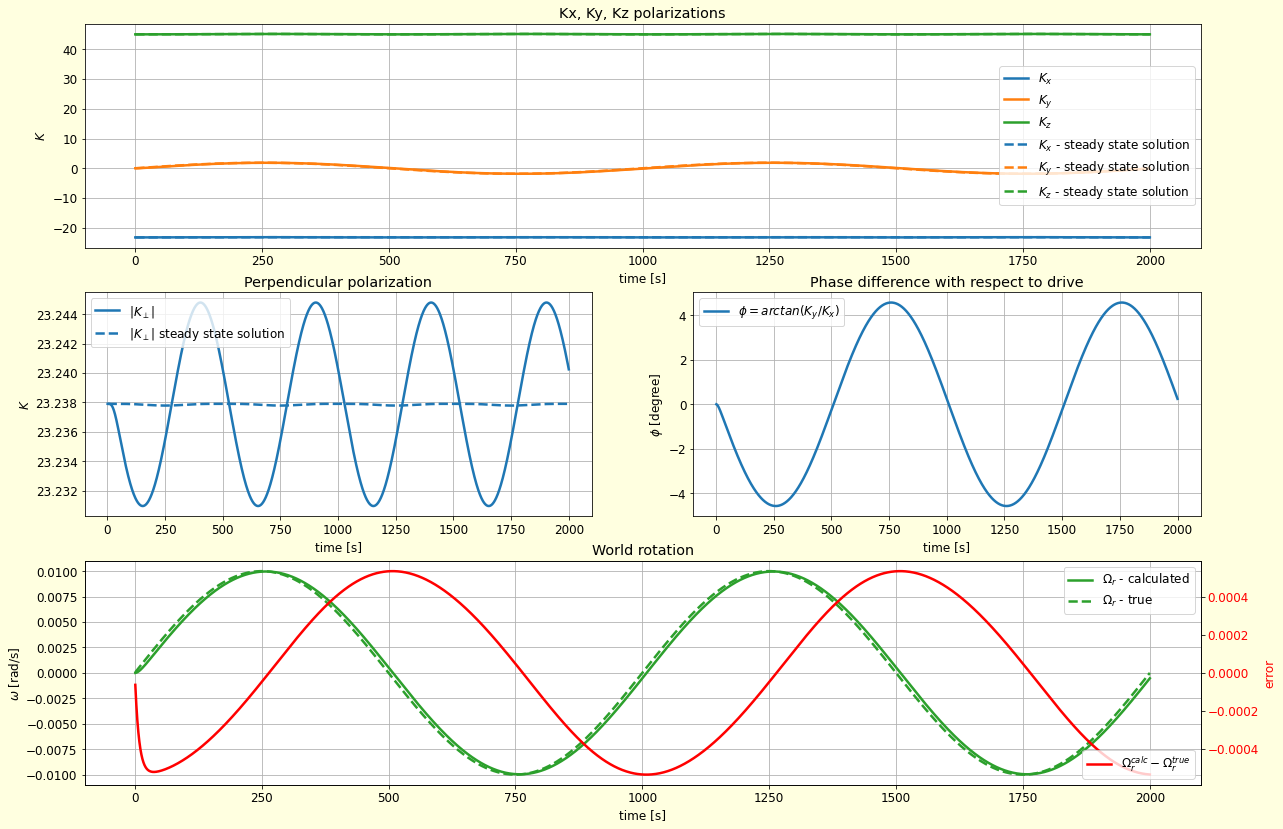

In [9]:
# run solver and save dynamics
Xe129.solve_dynamics(env129)
Xe129.plot_results(env129)

### Bandwidth simulation

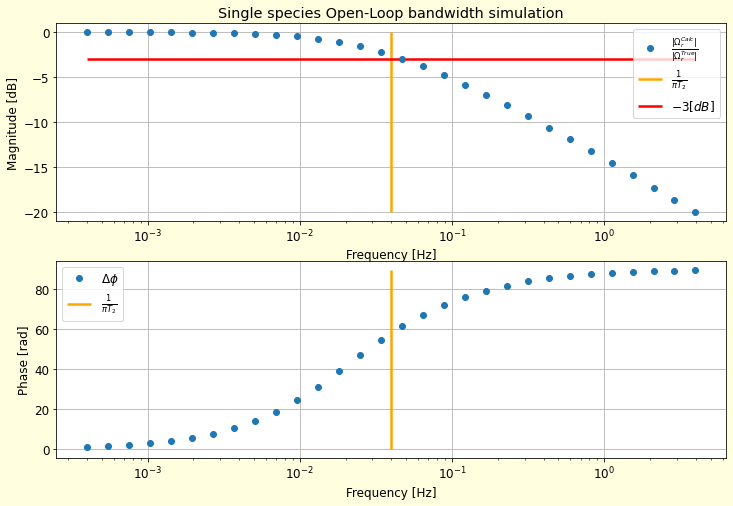

In [10]:
#@title Bandwidth simulation
t1 = 30 #@param {type:"slider", min:1, max:100, step:1}
t2 = 8 #@param {type:"slider", min:1, max:100, step:1}
Xenon_isotop = "129" #@param ["129", "131"]

if Xenon_isotop == '129':
    gyro = phy.G129
if Xenon_isotop == '131':
    gyro = phy.G131
    
meas.single_species_Open_Loop_bandwidth_simualtion(gyro, t1, t2)

We can see that the bandwidth of our system in open-loop configuration is determined by the $T_2$ value of the Xenon species. Larger $T_2$ would reulst in a smaller bandwidth and vice versa, so the bandwidth can also be exlained through the response time of our system. For simple enough systems we can compute the bandwidth of the system directly from the risetime $\tau_{r}$ of the system though the next rule of thumb relation $$f_{3[dB]} \approx \frac{0.35}{\tau_{r}}$$
For more information see [link](https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=9817).